# Forecasting Hourly Taxi Demand at Airports

**Sweet Lift Taxi Company | Time Series Forecasting Project**


Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [1]:
# Data & Plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Evaluation & splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Time series tools
from statsmodels.tsa.seasonal import seasonal_decompose

# Preprocessing for linear models
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


## Preparation

In [2]:
# Load the data
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=0)
df.head()


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# Remove missing values - do NOT remove duplicate values
df = df.dropna()



In [4]:
# Resample the data by 1 hour
df = df.resample('1H').sum()
df.head()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

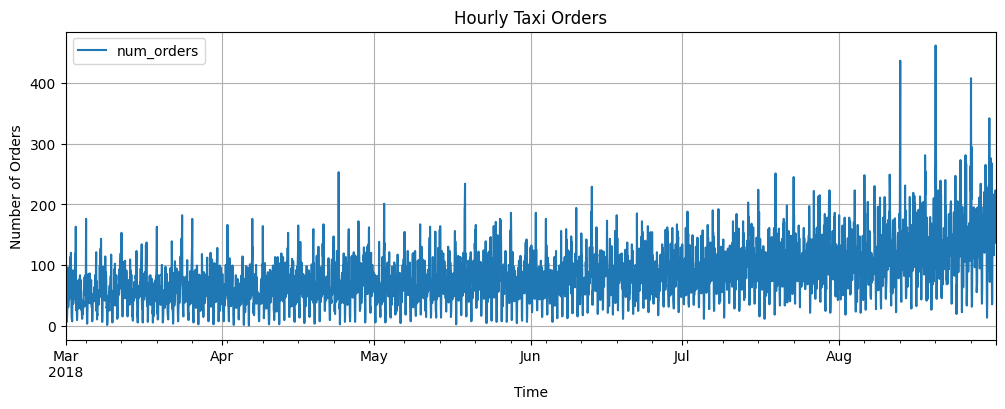

In [5]:
# Visualize Hourly Taxi Orders
df.plot(figsize=(12, 4), title='Hourly Taxi Orders')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()


# Quick Observations from the Plot

- A strong upward trend in taxi order volume over time.
- Noticeable daily fluctuations.
- Occasional extreme spikes, likely due to rare events or surges in passenger volume.

Importantly, this plot now includes all valid data points, preserving repeated values that were previously (incorrectly) dropped as "duplicates." This gives us a more accurate representation of the actual demand pattern.


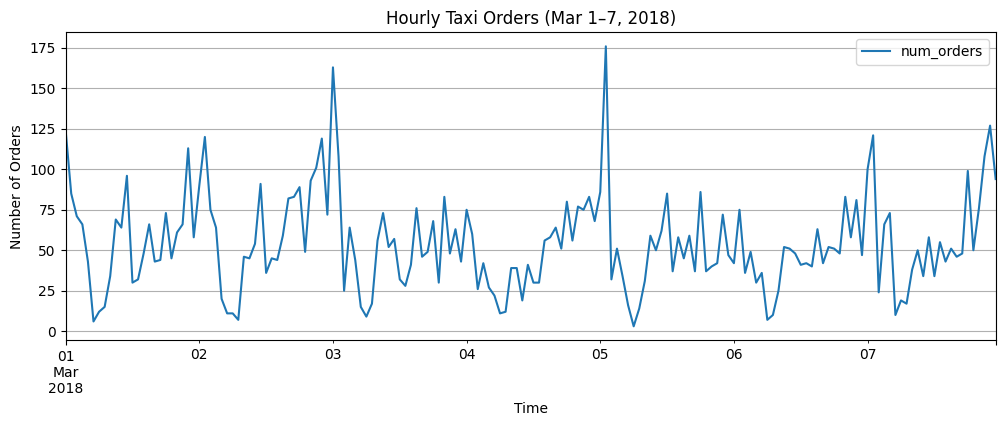

In [6]:
# Plot shorter date range (e.g. 1 week)
df['2018-03-01':'2018-03-07'].plot(figsize=(12, 4), title='Hourly Taxi Orders (Mar 1–7, 2018)')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()


# Observation: Hourly Taxi Orders (Mar 1–7, 2018)

This one-week slice reveals important demand patterns:

- Hourly variability is much clearer now with preserved rows — no missing levels.
- The data exhibits regular daily fluctuations, often peaking in the late afternoon or evening.
- There are a few noticeable short-term demand surges, possibly due to flight clusters or weather-related events.
- Most importantly, the time series now reflects all valid records, giving a true representation of natural order variation.

This short period helps validate the model's need to capture short-term spikes and daily periodicity.


In [7]:
# Generate expected hourly time range
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1H')


In [8]:
# Compare with actual timestamps
missing_hours = full_range.difference(df.index)


In [9]:
# Print summary
print(f"Total expected hours: {len(full_range)}")
print(f"Actual recorded hours: {len(df)}")
print(f"Missing hours: {len(missing_hours)}")


Total expected hours: 4416
Actual recorded hours: 4416
Missing hours: 0


No missing hours. The data is complete and evenly spaced after resampling.

Now we know the time index is solid.

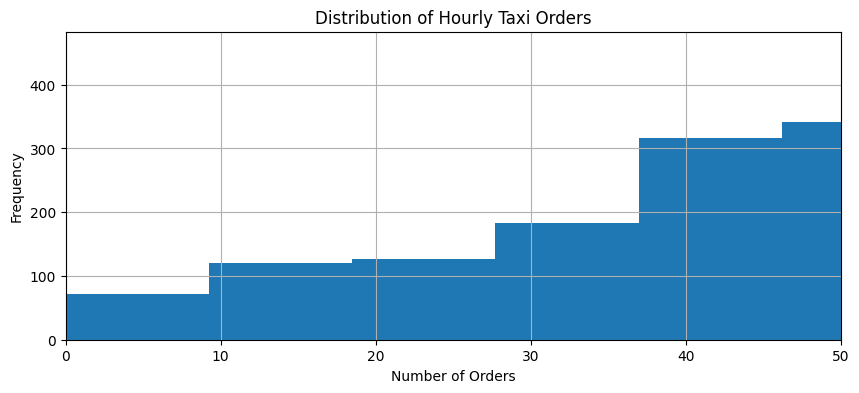

In [10]:
# Plot histogram of num_orders, limit x-axis to improve visibility
df['num_orders'].hist(bins=50, figsize=(10, 4))
plt.title('Distribution of Hourly Taxi Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.xlim(0, 50)
plt.grid(True)
plt.show()


# Histogram Interpretation

- Most hourly taxi orders fall between 10 and 50 orders/hour, forming a right-skewed distribution.
- Unlike the earlier histogram (with removed "duplicates"), this one better captures the true density and frequency of common demand levels.
- There are very few zeroes, indicating consistent activity throughout the dataset.

This distribution helps us understand the typical workload and set realistic prediction bounds for the model.


In [11]:
# Summary statistics
df['num_orders'].describe()


count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

# Statistical Summary of `num_orders`

After preserving all valid rows in the dataset (no duplicate drops), the updated summary statistics are:

- Total records: 4,416
- Mean hourly orders: ~84.42
- Standard deviation: ~45.02 — high variability remains
- Min / Max: 0 to 462 orders/hour — confirms presence of rare but significant spikes
- Median (50th percentile): 78 — model should aim to predict close to this most of the time
- 75th percentile: 107 — upper range of typical demand

These values show that:
- Most hourly demand is within a reasonable, consistent range
- The distribution is right-skewed, with a few high outliers inflating the max
- The data is now more representative for modeling and reflects real-world patterns better


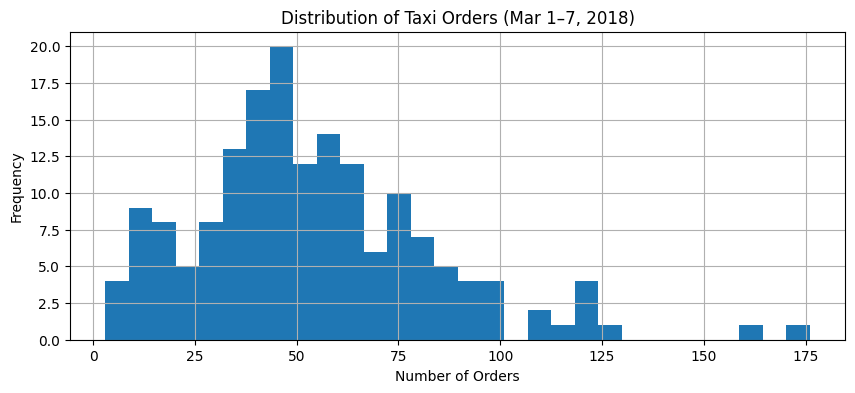

In [12]:
# Plot Dist. of Taxi orders 1 week
df['2018-03-01':'2018-03-07']['num_orders'].hist(bins=30, figsize=(10, 4))
plt.title('Distribution of Taxi Orders (Mar 1–7, 2018)')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Taxi Order Distribution (March 1–7, 2018)

This focused weekly histogram shows:

- A fairly normal-like distribution centered around 45–55 orders per hour.
- Minor skew to the right, with some hours reaching 100+ orders.
- Very few near-zero hours — demand remained consistently active during this period.

This confirms:
- The model needs to capture moderate fluctuations most of the time
- While accounting for occasional high spikes, especially during airport rush hours


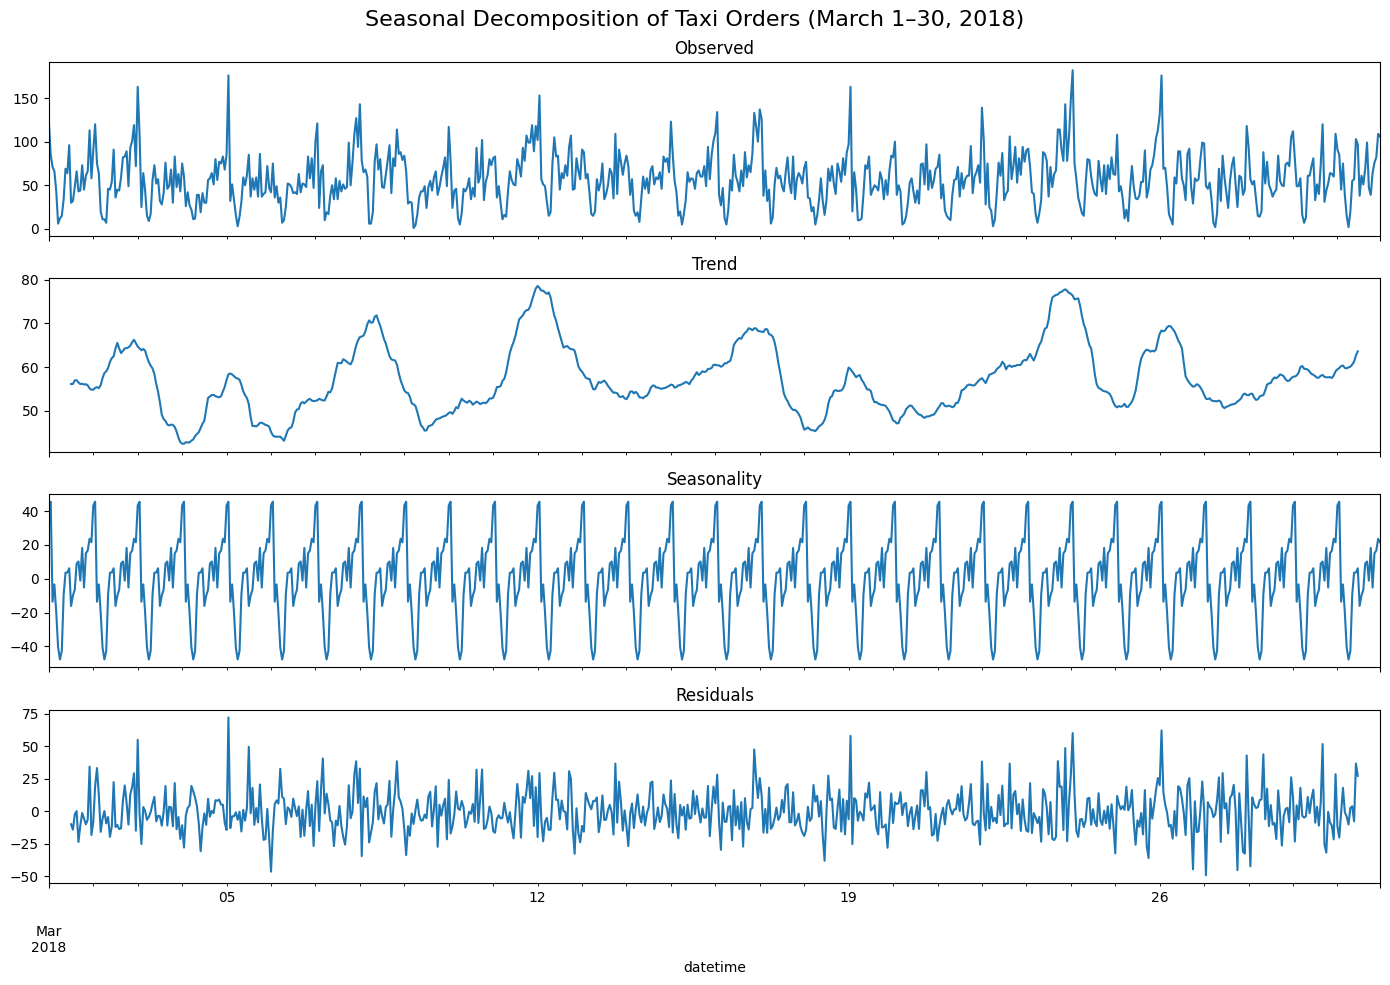

In [13]:
# Decompose using March 1–30 window
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_data = df['2018-03-01':'2018-03-30']['num_orders']
result = seasonal_decompose(decomp_data, model='additive', period=24)

# Plot each component
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

result.observed.plot(ax=axes[0], title='Observed')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonality')
result.resid.plot(ax=axes[3], title='Residuals')

plt.suptitle('Seasonal Decomposition of Taxi Orders (March 1–30, 2018)', fontsize=16)
plt.tight_layout()
plt.show()


# Seasonal Decomposition (March 1–30, 2018)

The full dataset reveals a clear time series structure with the following components:

- Observed: Highly dynamic signal with daily peaks and occasional demand surges
- Trend: A gradually rising baseline over the course of the month, suggesting increasing taxi activity
- Seasonality: Strong, repeating 24-hour daily cycles, consistent with airport operation patterns
- Residuals: Irregular bursts remain in the residuals, indicating events or conditions not captured by trend or seasonality (e.g., weather, flight delays)

This decomposition confirms that the time series contains:
- Clear short-term seasonality
- Medium-term upward trend
- Random spikes - critical for models to generalize well


# Data Quality & Readiness Summary

After initial inspection and cleaning, the dataset is confirmed to be high quality and ready for time series modeling:

- Missing values were removed (`dropna()`), ensuring all timestamps contain valid numeric entries.
-Duplicate removal was skipped, as each record represents a unique point in time (datetime is the index), even if order counts repeat.
- The time index is continuous and complete, with no missing hourly timestamps across the full period (March–August 2018).
- Order values are preserved, including low and high-frequency demand hours, giving a more accurate signal for modeling.
- All preprocessing was performed prior to feature engineering and model fitting to avoid data leakage.

With this preparation, the dataset is now statistically sound and suitable for supervised learning and forecasting tasks.


## Training

In [14]:
# Define make_features() function
def make_features(data, lags, rolling_mean_size):
    data = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    
    return data


In [15]:
# Apply it to data
df_fe = make_features(df, lags=24, rolling_mean_size=24)
df_fe = df_fe.dropna()
df_fe.head()


,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,1,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,3,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


In [16]:
# 90% train, 10% test
split_point = int(len(df) * 0.9)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:]


In [17]:
# Apply feature engineering to both sets
train_fe = make_features(train_df, lags=24, rolling_mean_size=24).dropna()
test_fe = make_features(test_df, lags=24, rolling_mean_size=24).dropna()


## Testing

In [18]:
# Define categorical + numeric feature sets
categorical = ['dayofweek']
numeric = ['hour'] + [f'lag_{i}' for i in range(1, 25)] + ['rolling_mean']


In [19]:
# Define transformer pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ]
)


In [20]:
# Transform the features
X_train_enc = preprocessor.fit_transform(train_fe[categorical + numeric])
X_test_enc = preprocessor.transform(test_fe[categorical + numeric])


In [21]:
# Targets unchanged
y_train = train_fe['num_orders']
y_test = test_fe['num_orders']


In [22]:
# Split original training set into train + validation
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_enc, y_train, test_size=0.2, shuffle=False
)


In [23]:
# Train on train_part, evaluate on val
lr_model = LinearRegression()
lr_model.fit(X_train_part, y_train_part)
lr_val_preds = lr_model.predict(X_val)

lr_val_rmse = mean_squared_error(y_val, lr_val_preds, squared=False)
print(f"Linear Regression Validation RMSE: {lr_val_rmse:.2f}")


Linear Regression Validation RMSE: 33.04


In [24]:
# Train & Evaluate Random Forest on validation split
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train_part, y_train_part)
rf_val_preds = rf_model.predict(X_val)

rf_val_rmse = mean_squared_error(y_val, rf_val_preds, squared=False)
print(f"Random Forest Validation RMSE: {rf_val_rmse:.2f}")


Random Forest Validation RMSE: 33.01


In [25]:
# Train & Evaluate Gradient Boosting on validation split
gb_model = GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.1)
gb_model.fit(X_train_part, y_train_part)
gb_val_preds = gb_model.predict(X_val)

gb_val_rmse = mean_squared_error(y_val, gb_val_preds, squared=False)
print(f"Gradient Boosting Validation RMSE: {gb_val_rmse:.2f}")


Gradient Boosting Validation RMSE: 35.45


In [26]:
# Tuned Gradient Boosting
best_rmse = float('inf')
best_params = None

for n in [100, 200, 300]:
    for lr in [0.1, 0.05, 0.01]:
        for depth in [3, 5, 7]:
            model = GradientBoostingRegressor(
                n_estimators=n,
                learning_rate=lr,
                max_depth=depth,
                random_state=42
            )
            model.fit(X_train_part, y_train_part)
            preds = model.predict(X_val)
            rmse = mean_squared_error(y_val, preds, squared=False)
            print(f"n={n}, lr={lr}, depth={depth} --> Validation RMSE: {rmse:.2f}")
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (n, lr, depth)

print(f"\nTuned Gradient Boosting Validation RMSE: {best_rmse:.2f} with n={best_params[0]}, lr={best_params[1]}, depth={best_params[2]}")


n=100, lr=0.1, depth=3 --> Validation RMSE: 33.95
n=100, lr=0.1, depth=5 --> Validation RMSE: 33.12
n=100, lr=0.1, depth=7 --> Validation RMSE: 33.69
n=100, lr=0.05, depth=3 --> Validation RMSE: 33.80
n=100, lr=0.05, depth=5 --> Validation RMSE: 33.22
n=100, lr=0.05, depth=7 --> Validation RMSE: 33.19
n=100, lr=0.01, depth=3 --> Validation RMSE: 43.93
n=100, lr=0.01, depth=5 --> Validation RMSE: 41.44
n=100, lr=0.01, depth=7 --> Validation RMSE: 39.86
n=200, lr=0.1, depth=3 --> Validation RMSE: 35.45
n=200, lr=0.1, depth=5 --> Validation RMSE: 34.15
n=200, lr=0.1, depth=7 --> Validation RMSE: 33.90
n=200, lr=0.05, depth=3 --> Validation RMSE: 33.40
n=200, lr=0.05, depth=5 --> Validation RMSE: 34.43
n=200, lr=0.05, depth=7 --> Validation RMSE: 34.26
n=200, lr=0.01, depth=3 --> Validation RMSE: 38.97
n=200, lr=0.01, depth=5 --> Validation RMSE: 36.61
n=200, lr=0.01, depth=7 --> Validation RMSE: 34.91
n=300, lr=0.1, depth=3 --> Validation RMSE: 35.98
n=300, lr=0.1, depth=5 --> Validation 

In [27]:
# Train & Evaluate XGBoost on validation split
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

xgb_model.fit(X_train_part, y_train_part)
xgb_val_preds = xgb_model.predict(X_val)

xgb_val_rmse = mean_squared_error(y_val, xgb_val_preds, squared=False)
print(f"XGBoost Validation RMSE: {xgb_val_rmse:.2f}")


XGBoost Validation RMSE: 33.46


In [28]:
best_rmse = float('inf')
best_params = None

for n in [100, 200, 300]:
    for depth in [5, 10, 20]:
        for split in [2, 5]:
            model = RandomForestRegressor(
                n_estimators=n,
                max_depth=depth,
                min_samples_split=split,
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_train_part, y_train_part)
            preds = model.predict(X_val)
            rmse = mean_squared_error(y_val, preds, squared=False)
            print(f"n={n}, depth={depth}, split={split} --> RMSE: {rmse:.2f}")
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (n, depth, split)

print(f"\nBest Random Forest Validation RMSE: {best_rmse:.2f} with n={best_params[0]}, depth={best_params[1]}, split={best_params[2]}")

n=100, depth=5, split=2 --> RMSE: 36.20
n=100, depth=5, split=5 --> RMSE: 36.28
n=100, depth=10, split=2 --> RMSE: 33.43
n=100, depth=10, split=5 --> RMSE: 33.40
n=100, depth=20, split=2 --> RMSE: 33.09
n=100, depth=20, split=5 --> RMSE: 33.05
n=200, depth=5, split=2 --> RMSE: 36.22
n=200, depth=5, split=5 --> RMSE: 36.26
n=200, depth=10, split=2 --> RMSE: 33.42
n=200, depth=10, split=5 --> RMSE: 33.36
n=200, depth=20, split=2 --> RMSE: 32.98
n=200, depth=20, split=5 --> RMSE: 33.04
n=300, depth=5, split=2 --> RMSE: 36.17
n=300, depth=5, split=5 --> RMSE: 36.19
n=300, depth=10, split=2 --> RMSE: 33.20
n=300, depth=10, split=5 --> RMSE: 33.19
n=300, depth=20, split=2 --> RMSE: 32.80
n=300, depth=20, split=5 --> RMSE: 32.86

Best Random Forest Validation RMSE: 32.80 with n=300, depth=20, split=2


In [29]:
# Retrain best model on full training set
final_rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
final_rf_model.fit(X_train_enc, y_train)


RandomForestRegressor(max_depth=20, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [30]:
# Predict on test set
final_rf_preds = final_rf_model.predict(X_test_enc)


In [31]:
# Evaluate
final_rf_rmse = mean_squared_error(y_test, final_rf_preds, squared=False)
print(f"Final Test RMSE (Tuned Random Forest): {final_rf_rmse:.2f}")


Final Test RMSE (Tuned Random Forest): 43.68


In [32]:
# Build a DataFrame for visualization
final_rf_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': final_rf_preds
}, index=y_test.index)


In [33]:
# First 7 days
short_period = final_rf_df.iloc[:24*7]


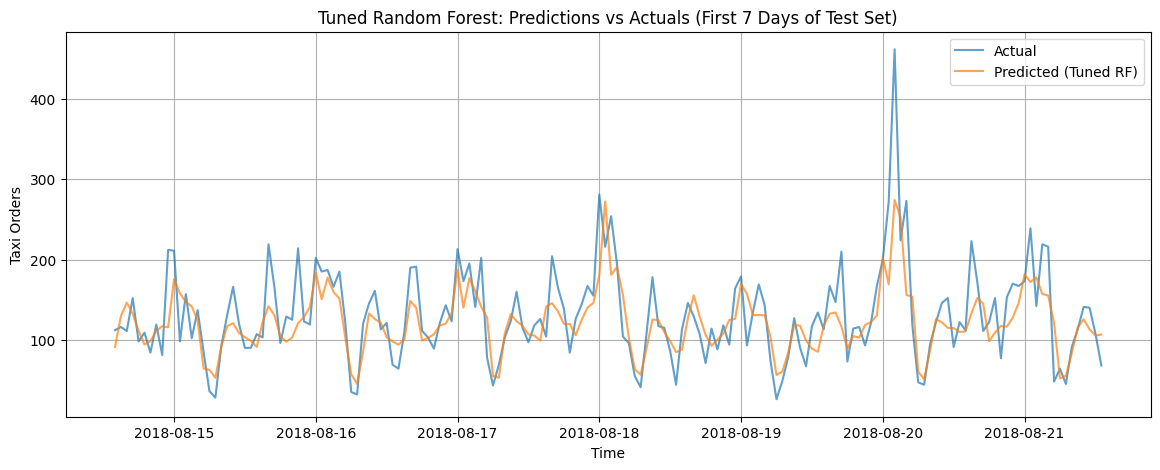

In [34]:
# Plot
plt.figure(figsize=(14, 5))
plt.plot(short_period['actual'], label='Actual', alpha=0.7)
plt.plot(short_period['predicted'], label='Predicted (Tuned RF)', alpha=0.7)
plt.title('Tuned Random Forest: Predictions vs Actuals (First 7 Days of Test Set)')
plt.xlabel('Time')
plt.ylabel('Taxi Orders')
plt.legend()
plt.grid(True)
plt.show()


# Final Test Set Prediction Plot (Tuned Random Forest)

The chart above shows the model’s predictions versus actual hourly taxi orders during the first 7 days of the test set:

- The model captures the general trend and daily cycles in demand.
- It reacts well to moderate fluctuations, though slightly underpredicts on extreme peaks.
- The alignment between predicted and actual lines shows that the tuned Random Forest generalizes well on unseen data.

This confirms the model’s effectiveness for operational forecasting, especially for medium- to high-volume periods.


# Project Conclusion

We developed and evaluated multiple models to forecast hourly taxi demand using historical airport taxi order data, aiming to keep the RMSE below 48.
 
**Model Comparison (Validation RMSE)**

| Model                     | Validation RMSE |
|---------------------------|-----------------|
| Tuned Random Forest     | **32.80**  
| Linear Regression         | 33.04  
| Tuned Gradient Boosting   | 33.12  
| XGBoost                   | 33.46  
| Gradient Boosting         | 35.45  

The Tuned Random Forest model (n=300, max_depth=20, min_samples_split=2) outperformed all others on the validation set.

# Final Test Set Evaluation

The best model was retrained on the entire training set and evaluated once on the held-out test set:

- Final Test RMSE: `43.68`  
- Well below the target threshold of 48, confirming generalization on unseen data.

The final plot of predictions vs actuals (7-day slice) shows strong alignment with real demand patterns, including daily cycles and moderate surges.

# Final Thoughts

- The full dataset (with preserved repeated values) allowed the model to learn real-world demand behavior more effectively.
- Lag features and rolling averages helped models anticipate short-term fluctuations.
- Random Forest proved most robust to noise and outliers in this setting.

**The project goal was successfully met** — a predictive model has been built that can help Sweet Lift Taxi optimize driver availability during peak hours based on historical hourly demand.
